# Chromatin Ensemble Refinement 
## 1. Objective 
* Infer the ensemble of chromatin structures $X = \{x_m\}$ and their weights $\alpha_m$ with $m \in {1, ..., M}$.
  * $M$ is the total number of structures. This is a predefined hyperparameter. This variable affects the accuracy and the stability of the ensemble refinement.
  * Here $M$ is the number of *true* chromatin states.
* Infer $X$ from a set of single-cell distance matrix $D_n$ with $n \in {1, ..., N}$.
  * $\mathcal{D} = {D_n}$ is the full sety of single-cell observations.

## 2. Forward Model 
* Each structure $x_m = \{\vec{r_i}\}_{i=1}^{N_{\text{probes}}}$.
  * $\vec{r_i}$ is a row vector with 3 columns represent a 3D position of probe $i$. 
* Assume that each chromatin is a polymer chain and a Gaussian noise for the measurements. 
  * If the distance matrix is complete, then there is a one-to-one correspondence between 3D structure and the distance matrix $$x \longleftrightarrow D$$
where $D_{ij} = \lVert \vec{r_i} - \vec{r_j} \rVert _2$
  

## 3. Posterior
* We will build on the methods developed for single-particle cryo-EM to develop the chromatin ensemble refinement pipeline.
* Posterior can be written as $$ p(\alpha, X| \mathcal{D}) \propto \prod_{n=1}^N \left[\sum_{m=1}^M \alpha_m \, p(D_n|x_m) \, p(\alpha_m) \, p(x_m) \right]$$

where $X = {x_m}$ is the ensemble of $M$ chromatin structures. 

* Here we assume that all single-cell measurements, the priors over weights $p(\alpha)$ and structures $p(x_m)$ are independent.
* Under the Gaussian noise model, we assume that all distance observations are i.i.d, so we can write $$p(D_n|x_m) = \prod_{i=1}^{N_{\text{probes}}}\prod_{j=1}^{N_{\text{probes}}}\frac{1}{\sqrt{2\pi}\sigma}\exp{\frac{(D_n^{ij}-D_m^{ij})^2}{2\sigma^2}} = \frac{1}{(\sqrt{2\pi}\sigma)^{N^2_{\text{probes}}}}\exp{\frac{-\lVert D_n - D_m \rVert _2^2}{2\sigma^2}}$$

In [1]:
import jax 
import scipy
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize 
from jax import grad, jit, vmap
from jax import random
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from scipy.spatial.distance import pdist, squareform

In [2]:
# define some helper functions 

def generate_gaussian_chain(num_monomers: int, 
                            mean_bond_length: float, 
                            std_bond_length: float):
    """Generate a Gaussian chain polymer 
    
    Parameters
    ----------
    num_monomers
    mean_bond_length
    std_bond_length
    
    Return
    ------
    np.array 
    
    Notes
    -----
    """ 
    # Generate steps: each step is a 3D vector 
    steps = np.random.normal(mean_bond_length, std_bond_length, size=(num_monomers, 3))
    
    # Compute positions by cumulative sum of steps
    positions = np.cumsum(steps, axis=0)
    
    return positions

In [3]:
def visualize_polymer(polymer_chain):
    """Plot a polymer chain in 3D space
    
    Parameters
    ----------
    polymer_chain
    
    Return
    ------
    
    """
    # Extract each coordinate of this polymer chain 
    x = polymer_chain[:, 0]
    y = polymer_chain[:, 1]
    z = polymer_chain[:, 2]
    
    # Intepolate path between monomer to show connectivity within the polymer
    # Parameterize by cumulative distance along the points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 + (z[1:] - z[:-1])**2)
    t = np.cumsum(t)
    
    # Create a cubic spline interpolation for each dimension
    cs_x = CubicSpline(t, x)
    cs_y = CubicSpline(t, y)
    cs_z = CubicSpline(t, z)
    
    # Normalize the monomer number 
    num_monomers = polymer_chain.shape[0] 
    norm_monomer_number = np.arange(0, num_monomers) / num_monomers
    monomer_colors = cm.rainbow(norm_monomer_number)

    # Generate fine samples for a smooth curve
    t_fine = np.linspace(t[0], t[-1], 500)
    x_fine = cs_x(t_fine)
    y_fine = cs_y(t_fine)
    z_fine = cs_z(t_fine)

    # Create a new matplotlib figure and an axes instance (the 3d part)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot using scatter
    ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
    for i in range(num_monomers):
        ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=50, alpha=0.75) 

    # Labeling the axes (optional but recommended for clarity)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Create a ScalarMappable with the same colormap and normalization as the scatter
    # sm = cm.ScalarMappable(cmap='rainbow', norm=norm_monomer_number)
    # sm.set_array([]) 
    
    # Add colorbar
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label('Monomer number')
    
    ax.legend()
    plt.show()


In [4]:
def compare_distance_maps(chain1, chain2, type1='polymer', type2='polymer'):
    """ Plot distance maps of chain1 and chain2 side-by-side
    
    Parameters
    ----------
    chain1
    chain2 
    type1
    type2

    """
    assert type1 in ('polymer', 'distance_map', 'flatten_distance_map')
    assert type2 in ('polymer', 'distance_map', 'flatten_distance_map')
    # Calculate pairwise distance maps
    if type1 == 'polymer':
        distance_map1 = squareform(pdist(chain1))
    elif type1 == 'flatten_distance_map':
        distance_map1 = np.reshape(chain1, [round(np.sqrt(chain1.shape[0])), round(np.sqrt(chain1.shape[0]))])
    else:
        distance_map1 = chain1
        
    if type2 == 'polymer':
        distance_map2 = squareform(pdist(chain2)) 
    elif type2 == 'flatten_distance_map':
        distance_map2 = np.reshape(chain2, [round(np.sqrt(chain2.shape[0])), round(np.sqrt(chain2.shape[0]))])
    else:
        distance_map2 = chain2
    
    # Determine the scale of colorbars
    # Both colorbars show data in the same range 
    cm_min = 0
    cm_max = np.max([np.max(distance_map1), np.max(distance_map2)])
    
    # Initialize new figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot distance maps 
    heatmap1 = ax1.imshow(distance_map1, cmap='hot', aspect='auto', vmin=cm_min, vmax=cm_max)
    ax1.set_title('Chain 1')
    cb1 = fig.colorbar(heatmap1, ax=ax1)
    cb1.set_label('Euclidean distance [a.u.]')
    
    heatmap2 = ax2.imshow(distance_map2, cmap='hot', aspect='auto', vmin=cm_min, vmax=cm_max)
    ax2.set_title('Chain 2')
    cb2 = fig.colorbar(heatmap2, ax=ax2)
    cb2.set_label('Euclidean distance [a.u.]')
    
    # Display the figure
    plt.tight_layout()
    plt.show()

In [5]:
def generate_flatten_distance_map(chain):
    """ 
    """
    return jnp.squeeze(jnp.reshape(squareform(pdist(chain)), [1, -1]))

In [6]:
# Example of a gaussian chain 
# with 1000 monomers, mean bond length = 10, and std bond length = 1
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

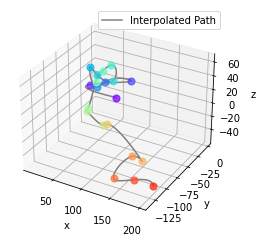

In [7]:
visualize_polymer(chain)

In [8]:
def calculate_end_to_end_distance(gaussian_polymer_chain):
    """ Calculate an end-to-end distance of a particular gaussian chain
    
    Parameters
    ----------
    gaussian_polymer_chain
    
    Return
    ------
    """
    return np.sqrt(np.sum((gaussian_polymer_chain[0, :] - gaussian_polymer_chain[-1, :])**2))
    

In [9]:
def calculate_gaussian_chain_conformation_prob(gaussian_polymer_chain):
    """Calculate the probability of a particular gaussian chain
    
    Parameters
    ----------
    gaussian_polymer_chain
    
    Return
    ------
    
    
    Notes
    -----
    """
    # Calculate square end-to-end distance of this gaussian chain
    end_to_end_distance_sq = np.sum((gaussian_polymer_chain[0, :] - gaussian_polymer_chain[-1, :])**2)
    
    # Calculate Kuhn length or average bond length of this gaussian chain
    mean_bond_length = np.mean(np.sqrt(np.sum(np.diff(gaussian_polymer_chain, n=1, axis=0)**2, 1)))
    
    # Calculate the number of monomers in this polymer chain
    num_monomers = gaussian_polymer_chain.shape[0]
    
    # Calculate probability according to the theory note 
    prob = ((3/(2*np.pi*num_monomers*mean_bond_length**2)) ** 1.5) * np.exp(-3*end_to_end_distance_sq/(2*num_monomers*mean_bond_length**2))
    
    return prob    
    
    

In [10]:
calculate_gaussian_chain_conformation_prob(chain)

9.838160001106556e-09

In [11]:
# This is the likelihood function
def calculate_distance_map_prob_given_gaussian_chain(theta):
    """Calculate the probability of observing a particular distance map given a 
    simulated gaussian chain and the standard deviation of measurement error 
    
    Parameters
    ----------
    theta
    sim_distance_map
    num_probes
    
    Return
    ------
    
    
    Notes
    -----
    """
    measurement_error_std = 10
    
    # sim_distance_map_flat = theta[:-1]
    # measurement_error_std = jnp.exp(theta[-1])
    sim_distance_map_flat = theta 
    
    # Find the subtraction between empirical and simulated distance maps
    subtraction_map = jnp.squeeze(jnp.reshape(empirical_distance_map_flat, [1, -1])) - jnp.squeeze(jnp.reshape(sim_distance_map_flat, [1, -1]))
    subtraction_map_sq = subtraction_map ** 2
    print(jnp.sum(subtraction_map_sq))
    
    # Calculate the normalization factor 
    # See the theory note
    normalization_factor = 1/((jnp.sqrt(2*np.pi)*measurement_error_std)**((num_probes)**2))
    
    
    # Calculate the exponential decay term 
    # See the theory note
    gaussian_term = jnp.exp(-jnp.sum(subtraction_map_sq)/(2*measurement_error_std**2))
    
    
    return normalization_factor * gaussian_term

In [12]:
# This is the likelihood function
def calculate_negative_loglikelihood(theta):
    """Calculate the probability of observing a particular distance map given a 
    simulated gaussian chain and the standard deviation of measurement error 
    
    Parameters
    ----------
    theta
    sim_distance_map
    num_probes
    
    Return
    ------
    
    
    Notes
    -----
    """
    # Currently, learning measurement error does not work 
    # sim_distance_map_flat = theta[:-1]
    # measurement_error_std = jnp.exp(theta[-1])
    sim_distance_map_flat = theta
    
    # Find the subtraction between empirical and simulated distance maps
    subtraction_map = jnp.squeeze(jnp.reshape(empirical_distance_map_flat, [1, -1])) - jnp.squeeze(jnp.reshape(sim_distance_map_flat, [1, -1]))
    subtraction_map_sq = subtraction_map ** 2
    
    ll = (-0.5 * num_probes**2) * jnp.log(2*jnp.pi*measurement_error_std**2) - jnp.sum(subtraction_map_sq/(2*measurement_error_std**2))
    return -ll / (num_probes ** 2)

In [13]:
# This is the likelihood function
def calculate_negative_loglikelihood_with_weight(theta):
    """Calculate the probability of observing a particular distance map given a 
    simulated gaussian chain and the standard deviation of measurement error 
    
    Parameters
    ----------
    theta
    sim_distance_map
    num_probes
    
    Return
    ------
    
    
    Notes
    -----
    """
    # Currently, learning measurement error does not work 
    # sim_distance_map_flat = theta[:-1]
    # measurement_error_std = jnp.exp(theta[-1])
    sim_distance_map_flat = theta
    
    
    # Find the subtraction between empirical and simulated distance maps
    subtraction_map = jnp.squeeze(jnp.reshape(empirical_distance_map_flat, [1, -1])) - jnp.squeeze(jnp.reshape(sim_distance_map_flat, [1, -1]))
    subtraction_map_sq = subtraction_map ** 2
    
    ll = (-0.5 * num_probes**2) * jnp.log(2*jnp.pi*measurement_error_std**2) - jnp.sum(subtraction_map_sq/(2*measurement_error_std**2))
    return -ll / (num_probes ** 2)

In [14]:
# This is the likelihood function
def calculate_loglikelihood(theta, empirical_distance_map_flat, num_probes):
    """Calculate the probability of observing a particular distance map given a 
    simulated gaussian chain and the standard deviation of measurement error 
    
    Parameters
    ----------
    theta
    sim_distance_map
    num_probes
    
    Return
    ------
    
    
    Notes
    -----
    """
    measurement_error_std = 10
    # Currently, learning measurement error does not work 
    # sim_distance_map_flat = theta[:-1]
    # measurement_error_std = jnp.exp(theta[-1])
    sim_distance_map_flat = theta
    
    # Find the subtraction between empirical and simulated distance maps
    subtraction_map = jnp.squeeze(jnp.reshape(empirical_distance_map_flat, [1, -1])) - jnp.squeeze(jnp.reshape(sim_distance_map_flat, [1, -1]))
    subtraction_map_sq = subtraction_map ** 2
    
    ll = (-0.5 * num_probes**2) * jnp.log(2*jnp.pi*measurement_error_std**2) - jnp.sum(subtraction_map_sq/(2*measurement_error_std**2))
    return ll

In [15]:
# Plot the comparison between template chain and noisy chain
def compare_polymer_chains(chain1, chain2): 
    """ Visualize chain1 and chain2 side-by-side
    
    Parameters
    ----------
    chain1
    chain2 

    """
    # Initialize new figure
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    axs = [ax1, ax2]
    
    # Put polymer chains in the same data structure 
    chains = [chain1, chain2]
    
    # Plot polymer chain
    for poly_num, ax in enumerate(axs):
        polymer_chain = chains[poly_num]
        
        # Extract each coordinate of this polymer chain 
        x = polymer_chain[:, 0]
        y = polymer_chain[:, 1]
        z = polymer_chain[:, 2]
        
        # Intepolate path between monomer to show connectivity within the polymer
        # Parameterize by cumulative distance along the points
        t = np.zeros(x.shape)
        t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 + (z[1:] - z[:-1])**2)
        t = np.cumsum(t)
        
        # Create a cubic spline interpolation for each dimension
        cs_x = CubicSpline(t, x)
        cs_y = CubicSpline(t, y)
        cs_z = CubicSpline(t, z)
        
        # Normalize the monomer number 
        num_monomers = polymer_chain.shape[0] 
        norm_monomer_number = np.arange(0, num_monomers) / num_monomers
        monomer_colors = cm.rainbow(norm_monomer_number)

        # Generate fine samples for a smooth curve
        t_fine = np.linspace(t[0], t[-1], 500)
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        z_fine = cs_z(t_fine)
        
        
        # Plot using scatter
        ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
        for i in range(num_monomers):
            ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=50, alpha=0.75) 

        # Labeling the axes (optional but recommended for clarity)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

    plt.show()
    

In [11]:
empirical_distance_map_flat = jnp.reshape(squareform(pdist(chain)), [1, -1])
num_probes = num_monomers
measurement_error_std = 1e-3

In [12]:
jacobian = jax.jacfwd(calculate_negative_loglikelihood)
hessian = jax.hessian(calculate_negative_loglikelihood)

In [13]:
simulated_chain =  generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

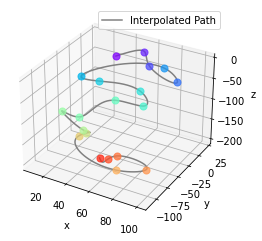

In [14]:
visualize_polymer(simulated_chain)

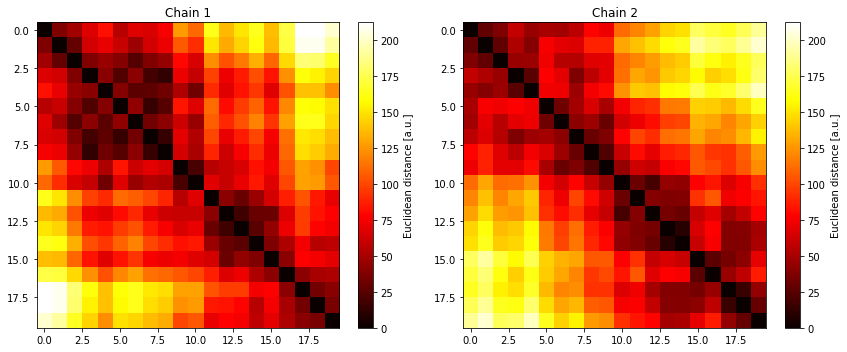

In [15]:
compare_distance_maps(chain, simulated_chain)

In [16]:
simulated_map_flatten = jnp.squeeze(jnp.reshape(squareform(pdist(simulated_chain)), [1, -1]))

In [17]:
simulated_map_flatten.shape

(400,)

In [20]:
theta = simulated_map_flatten
# print(f'Jacobian: {jacobian(theta)}\n')
# print(f'Hessian: {hessian(theta)}\n')

In [28]:
theta_start = theta
result_distance_map = minimize(calculate_negative_loglikelihood, theta_start, method='BFGS',
                               options={'disp': True, 'gtol':1e-2*num_monomers**2}, jac=jacobian)
# Notice here that tolerance is 1e-3 

print("Convergence Achieved: ", result_distance_map.success)
print("Number of Function Evaluations: ", result_distance_map.nfev)

Optimization terminated successfully.
         Current function value: -5.883155
         Iterations: 24
         Function evaluations: 49
         Gradient evaluations: 49
Convergence Achieved:  True
Number of Function Evaluations:  49


In [97]:
theta_start.shape

(400,)

In [29]:
result_distance_map

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.883155345916748
        x: [ 0.000e+00  3.670e+01 ...  3.560e+01  0.000e+00]
      nit: 24
      jac: [ 0.000e+00 -1.001e+00 ... -3.052e-01  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  9.928e-01 ... -2.208e-03  0.000e+00]
            ...
            [ 0.000e+00 -2.208e-03 ...  9.952e-01  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 49
     njev: 49

In [30]:
result_distance_map.jac

array([ 0.        , -1.001358  ,  0.09536743, -1.2016296 , -0.64849854,
       -1.0585785 , -1.4686584 ,  1.1634827 , -0.05722046, -0.36239624,
        0.2861023 , -2.5939941 , -2.0599365 ,  0.4196167 ,  1.9454956 ,
       -0.30517578,  1.0299683 , -2.937317  , -2.4795532 ,  2.708435  ,
       -1.001358  ,  0.        , -0.24318695, -0.0667572 , -0.9727478 ,
        1.3256073 ,  0.8583069 , -0.2670288 ,  0.2861023 , -0.03814697,
        0.38146973, -0.7247925 ,  0.38146973,  0.76293945, -1.373291  ,
        2.1362305 , -0.61035156, -0.9536743 ,  0.38146973,  0.11444092,
        0.09536743, -0.24318695,  0.        ,  0.4386902 ,  0.4386902 ,
        1.8405914 ,  0.6866455 ,  0.29563904,  0.98228455, -0.705719  ,
        0.30517578, -1.5640259 ,  0.09536743,  0.49591064,  2.0599365 ,
        2.3269653 ,  0.22888184, -2.0980835 , -0.34332275, -0.91552734,
       -1.2016296 , -0.0667572 ,  0.4386902 ,  0.        , -0.64849854,
        1.3875961 ,  0.81062317,  0.54836273,  0.95129013,  1.35

In [31]:
result_distance_map.x.reshape([num_monomers, num_monomers])

array([[  0.        ,  36.70394458,  48.47726977,  66.6064915 ,
         82.46552114,  55.31197072,  67.78963545,  65.71535911,
         75.18445652, 126.50393532, 110.5533431 , 163.30128764,
        136.05247202, 150.51197026, 164.49061931, 137.99379393,
        172.57345779, 212.18717009, 212.15569929, 201.56287914],
       [ 36.70394458,   0.        ,  28.58395536,  63.51841547,
         70.47883076,  60.30273476,  47.22885629,  63.17399251,
         71.48191206, 105.80101767,  91.71214964, 150.69695359,
        131.18847969, 144.52783831, 160.93705579, 136.14919407,
        171.44211844, 208.44237649, 208.21061097, 192.13970076],
       [ 48.47726977,  28.58395536,   0.        ,  37.63328634,
         45.05779234,  38.99193549,  23.62784674,  37.52061633,
         44.27704637,  80.09180248,  65.93090826, 122.51236214,
        102.84693153, 115.98690711, 132.7661555 , 109.51526288,
        146.2202216 , 182.81766897, 180.82389082, 165.33062041],
       [ 66.6064915 ,  63.51841547,  

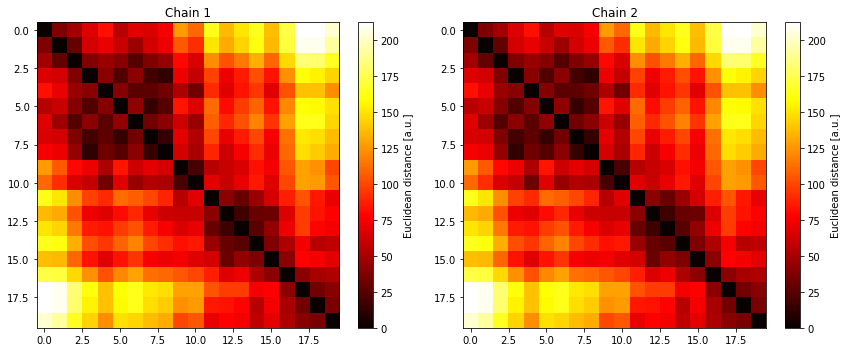

In [32]:
compare_distance_maps(chain, result_distance_map.x.reshape([num_monomers, num_monomers]), type2='distance_map')

## Finding the likelihood curve 
Here I will generate a number of polymer chains, calculate their likelihood values, optimize them to see if they converge to the "true" polymer chain. 

In [16]:
def generate_observations(polymer_chain, num_observations, gaussian_noise_std):
    """ Given a template polymer chain, generate num_observations polymer chains by adding 
    some gaussian noise to the polymer chain
    
    Parameters
    ----------
    polymer_chain
    num_observations
    gaussian_noise_std
    
    Return
    ------
    """
    observation_list = []
    polymer_size = polymer_chain.shape 
    
    # Parameters for Gaussian noise 
    mean = 0 
    std = gaussian_noise_std
    
    for i in range(num_observations):
        # Generate Gaussian Noise 
        noise = np.random.normal(mean, std, polymer_size)
        
        # Add noise to the original data
        noisy_data = polymer_chain + noise 
        
        # Append this observation to the list
        observation_list.append(noisy_data)
    
    return observation_list

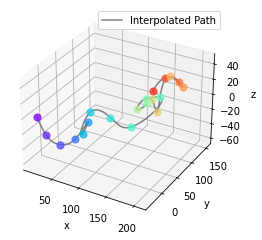

In [179]:
num_simulated_chains = 1000

num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
empirical_distance_map_flat = generate_flatten_distance_map(template_chain)
visualize_polymer(template_chain)

num_observations = 1000
gaussian_noise_std = 10

simulated_chain_list = generate_observations(template_chain, num_observations, gaussian_noise_std)
jacobian = jax.jacfwd(calculate_negative_loglikelihood)

In [180]:
simulated_map_flat_list = [generate_flatten_distance_map(poly) for poly in simulated_chain_list]

In [181]:
nll_list = [calculate_negative_loglikelihood(f_map) for f_map in simulated_map_flat_list]

In [182]:
nll_empirical = calculate_negative_loglikelihood(empirical_distance_map_flat)

In [ ]:
optimized_nll_list = [minimize(calculate_negative_loglikelihood, theta_start, method='BFGS',
                               options={'disp': False, 'gtol':1e-3*num_monomers**2}, jac=jacobian) for theta_start in simulated_map_flat_list]

In [183]:
# Define a class to keep track of optimization paths 
class OptimizationTracker:
    def __init__(self):
        self.runs = []

    def add_run(self, x0, result):
        # Stores each run information in a dictionary
        self.runs.append({
            'initial': x0,
            'history': np.array(result['history']),
            'final': result['final']
        })

    def plot_runs(self):
        # Plot the path of each optimization run
        plt.figure(figsize=(12, 6))
        for index, run in enumerate(self.runs):
            history = run['history']
            plt.plot(np.arange(len(history)), history, 'o-', label='Run {}'.format(index))
            plt.plot(len(history), run['final'], 'rx')  # Mark the final point
        plt.title('Paths of Multiple Optimization Runs')
        plt.xlabel('Iteration')
        plt.ylabel('Negative log-likelihood')
        plt.legend()
        plt.grid(True)
        plt.show()


In [184]:
# Run multiple optimizations
tracker = OptimizationTracker()

for theta_start in tqdm(simulated_map_flat_list):
    history = []
    def callback(x):
        history.append(calculate_negative_loglikelihood(x))

    res = minimize(calculate_negative_loglikelihood, theta_start, method='BFGS', callback=callback,
                               options={'disp': False, 'gtol':1e-3*num_monomers**2}, jac=jacobian) 
    tracker.add_run(calculate_negative_loglikelihood(theta_start), {'history': history, 'final': res.fun})


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
tracker.plot_runs() # This show that all these simulations converge to global minimum 

Text(0.5, 1.0, 'Histogram of Negative Log-likelihood')

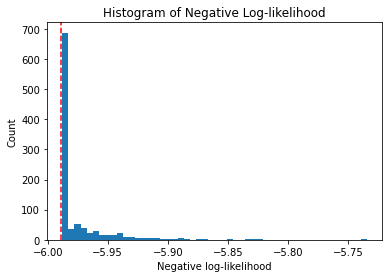

In [187]:
plt.hist([x['final'] for x in tracker.runs], bins=50)
plt.axvline(nll_empirical, color='r', linestyle='--', label='True NLL')
plt.xlabel('Negative log-likelihood')
plt.ylabel('Count')
plt.title('Histogram of Negative Log-likelihood')

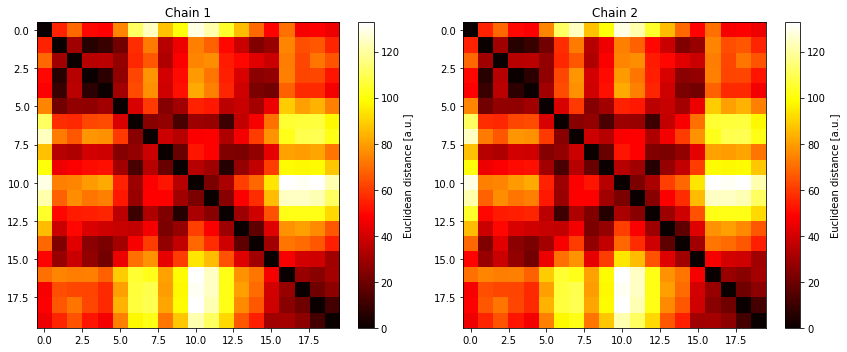

In [192]:
compare_distance_maps(chain, optimized_nll_list[80].x, type2='flatten_distance_map')

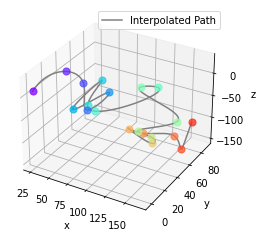

In [60]:
visualize_polymer(chain)

In [164]:
nll_empirical

Array(-5.9888167, dtype=float32)

In [70]:
prior_list = [calculate_gaussian_chain_conformation_prob(poly) for poly in simulated_chain_list]

In [71]:
end_to_end_dist_list = [calculate_end_to_end_distance(poly) for poly in simulated_chain_list]

In [57]:
prior_list[:5]

[1.3150012736540283e-08,
 8.947991542254641e-08,
 3.6675500794941e-08,
 3.334590778412699e-08,
 5.712944583836537e-08]

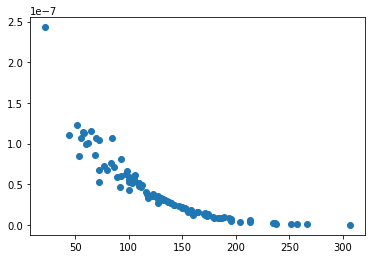

In [72]:
plt.scatter(end_to_end_dist_list, prior_list)

## Minimize negative log-likelihood with ensemble weights
Case 1: there is one chromatin state. 

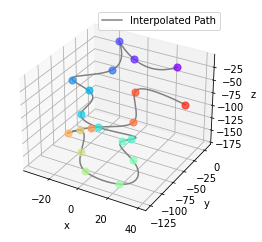

In [167]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
visualize_polymer(template_chain)

In [169]:
num_observations = 1000
gaussian_noise_std = 10

observation_list = generate_observations(template_chain, num_observations, gaussian_noise_std)

In [170]:
# Plot the comparison between template chain and noisy chain
def compare_polymer_chains(chain1, chain2): 
    """ Visualize chain1 and chain2 side-by-side
    
    Parameters
    ----------
    chain1
    chain2 

    """
    # Initialize new figure
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    axs = [ax1, ax2]
    
    # Put polymer chains in the same data structure 
    chains = [chain1, chain2]
    
    # Plot polymer chain
    for poly_num, ax in enumerate(axs):
        polymer_chain = chains[poly_num]
        
        # Extract each coordinate of this polymer chain 
        x = polymer_chain[:, 0]
        y = polymer_chain[:, 1]
        z = polymer_chain[:, 2]
        
        # Intepolate path between monomer to show connectivity within the polymer
        # Parameterize by cumulative distance along the points
        t = np.zeros(x.shape)
        t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 + (z[1:] - z[:-1])**2)
        t = np.cumsum(t)
        
        # Create a cubic spline interpolation for each dimension
        cs_x = CubicSpline(t, x)
        cs_y = CubicSpline(t, y)
        cs_z = CubicSpline(t, z)
        
        # Normalize the monomer number 
        num_monomers = polymer_chain.shape[0] 
        norm_monomer_number = np.arange(0, num_monomers) / num_monomers
        monomer_colors = cm.rainbow(norm_monomer_number)

        # Generate fine samples for a smooth curve
        t_fine = np.linspace(t[0], t[-1], 500)
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        z_fine = cs_z(t_fine)
        
        
        # Plot using scatter
        ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
        for i in range(num_monomers):
            ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=50, alpha=0.75) 

        # Labeling the axes (optional but recommended for clarity)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

    plt.show()
    

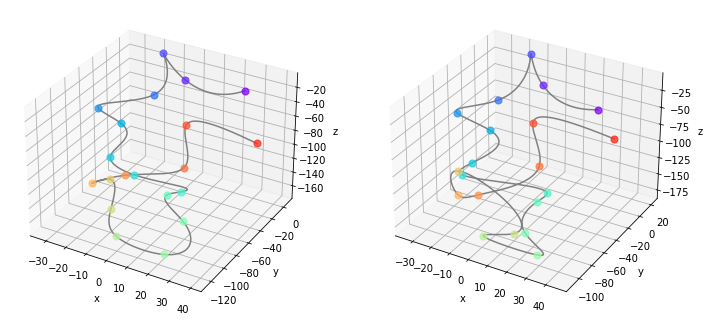

In [172]:
observation_number = 21
compare_polymer_chains(template_chain, observation_list[observation_number])

In [188]:
# We can change the function such that it takes in a scalar observation  

def calculate_unnormalized_negative_logposterior(polymer_chain_list):
    """ 
    """
    result = 0
    for polymer_chain in polymer_chain_list:
        theta = generate_flatten_distance_map(polymer_chain)
        result += calculate_negative_loglikelihood(theta) - jnp.log(calculate_gaussian_chain_conformation_prob(polymer_chain))
    return result

In [189]:
jacobian_negative_logposterior = jax.jacfwd(calculate_unnormalized_negative_logposterior)

In [190]:
empirical_distance_map_flat = generate_flatten_distance_map(template_chain)

In [199]:
res = minimize(calculate_unnormalized_negative_logposterior, observation_list, method='BFGS',
                               options={'disp': False, 'gtol':1e-6*num_observations*num_monomers**2}, jac=jacobian_negative_logposterior)

# This does not work I should use cvxpy

ValueError: 'x0' must only have one dimension.

In [198]:
np.atleast_1d(np.asarray(observation_list)).ndim

3

# Use cvxpy to minimize posterior function
1. Try constant prior and then perform the maximum a posterior 

In [19]:
import cvxpy as cp

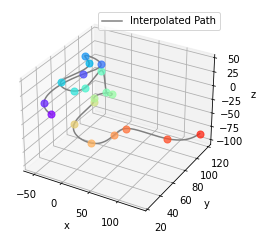

In [18]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
visualize_polymer(template_chain)

num_observations = 5000
gaussian_noise_std = 10

observation_list = generate_observations(template_chain, num_observations, gaussian_noise_std)

In [19]:
observation_distance_map_list = [squareform(pdist(poly)) for poly in observation_list]

In [20]:
X = cp.Variable((num_monomers, num_monomers))

objective = cp.Minimize(sum([cp.sum_squares(x - X) for x in observation_distance_map_list]))

problem = cp.Problem(objective)
problem.solve()

/Users/teeu/venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


345109078.21672887

In [21]:
np.sqrt(problem.value/(num_observations * num_monomers**2))

13.136001640848116

In [22]:
X.value

array([[ -0.        ,  33.22186154,  50.55894457,  86.33187616,
         45.87890252, 104.52843003,  95.79225287, 106.86034045,
        117.98456068,  91.30232784, 101.93550274,  78.42811807,
         79.54578322,  82.92186467, 118.4758099 , 138.69360484,
        118.30196298, 129.59090301, 119.68527977, 121.3291106 ],
       [ 33.22186154,  -0.        ,  67.13303393, 108.44037671,
         68.86723612, 125.89677197, 118.91140516, 130.27153776,
        142.03877568, 115.32229891, 126.62846271, 102.8711886 ,
        101.62251533, 104.9207847 , 139.01346932, 162.08227816,
        141.53844397, 154.65426777, 144.51546541, 145.75307342],
       [ 50.55894457,  67.13303393,  -0.        ,  54.60467315,
         47.95621414,  65.02855356,  63.15575914,  74.75632152,
         87.66480663,  82.73847211,  79.73355826,  58.09236383,
         67.44716484,  71.22590275,  92.45066639, 113.32039491,
         90.97905048, 108.16423692, 100.97872409, 104.39113068],
       [ 86.33187616, 108.44037671,  

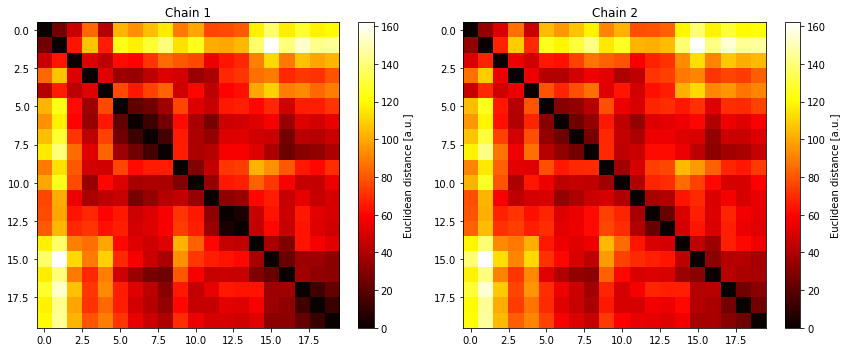

In [23]:
compare_distance_maps(template_chain, X.value, type2='distance_map')

In [24]:
np.sqrt(np.mean((squareform(pdist(template_chain)) - X.value)**2))

4.4659160355603476

In [20]:
num_observations = 10
template_chain_1 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
observation_list_1 = generate_observations(template_chain_1, num_observations, gaussian_noise_std)
observation_dmap_list_1 = [squareform(pdist(poly)) for poly in observation_list_1]

template_chain_2 = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
observation_list_2 = generate_observations(template_chain_2, num_observations, gaussian_noise_std)
observation_dmap_list_2 = [squareform(pdist(poly)) for poly in observation_list_2]

In [22]:
observation_dmap_list_all = np.vstack([observation_dmap_list_1, observation_dmap_list_2])

In [34]:
observation_dmap_list_all[0, :, :]

array([[  0.        ,  76.18819647,  95.49090702,  92.04555796,
         85.39233575,  98.10178106, 108.92783023, 134.39325597,
        139.40467002, 109.67746138, 121.83315124,  71.10760895,
        139.5728848 , 118.05490976, 153.44410018, 178.57009616,
        203.62933111, 276.2891176 , 264.78426235, 281.1283428 ],
       [ 76.18819647,   0.        ,  36.18807315,  25.55629896,
         52.9107322 ,  55.97376516,  73.3778708 , 110.58359181,
        114.79003064,  52.005933  ,  81.36870418,  52.69355118,
         88.70907828,  75.07551357, 115.46428193, 129.03720207,
        166.49422601, 251.39906737, 238.5412374 , 266.23620564],
       [ 95.49090702,  36.18807315,   0.        ,  43.32456575,
         71.90302945,  60.70651611,  92.7092413 , 136.20395142,
        138.44075153,  53.95943849,  94.55499154,  74.12150353,
         86.70319096,  76.73480847, 120.42537346, 129.29485457,
        162.69126688, 244.21415151, 223.93722748, 256.79663537],
       [ 92.04555796,  25.55629896,  

In [56]:
# This method does not work because it is not a convex function 
X1 = cp.Variable((num_monomers, num_monomers), nonneg=True)
X2 = cp.Variable((num_monomers, num_monomers), nonneg=True)

objective = cp.Minimize(cp.sum([-cp.log(cp.exp(cp.sum_squares(x - X1)) + cp.exp(cp.sum_squares(x - X2))) for x in observation_dmap_list_all]))

problem = cp.Problem(objective)
problem.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
log(exp(quad_over_lin([[0.00 76.19 ... 264.78 281.13]
 [76.19 0.00 ... 238.54 266.24]
 ...
 [264.78 238.54 ... 0.00 54.22]
 [281.13 266.24 ... 54.22 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 76.19 ... 264.78 281.13]
 [76.19 0.00 ... 238.54 266.24]
 ...
 [264.78 238.54 ... 0.00 54.22]
 [281.13 266.24 ... 54.22 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 81.96 ... 265.67 269.79]
 [81.96 0.00 ... 233.01 244.86]
 ...
 [265.67 233.01 ... 0.00 27.37]
 [269.79 244.86 ... 27.37 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 81.96 ... 265.67 269.79]
 [81.96 0.00 ... 233.01 244.86]
 ...
 [265.67 233.01 ... 0.00 27.37]
 [269.79 244.86 ... 27.37 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 46.31 ... 249.51 254.05]
 [46.31 0.00 ... 227.17 234.40]
 ...
 [249.51 227.17 ... 0.00 18.30]
 [254.05 234.40 ... 18.30 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 46.31 ... 249.51 254.05]
 [46.31 0.00 ... 227.17 234.40]
 ...
 [249.51 227.17 ... 0.00 18.30]
 [254.05 234.40 ... 18.30 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 40.06 ... 241.71 271.31]
 [40.06 0.00 ... 237.40 266.50]
 ...
 [241.71 237.40 ... 0.00 36.94]
 [271.31 266.50 ... 36.94 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 40.06 ... 241.71 271.31]
 [40.06 0.00 ... 237.40 266.50]
 ...
 [241.71 237.40 ... 0.00 36.94]
 [271.31 266.50 ... 36.94 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 66.03 ... 231.98 282.53]
 [66.03 0.00 ... 221.10 270.33]
 ...
 [231.98 221.10 ... 0.00 58.01]
 [282.53 270.33 ... 58.01 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 66.03 ... 231.98 282.53]
 [66.03 0.00 ... 221.10 270.33]
 ...
 [231.98 221.10 ... 0.00 58.01]
 [282.53 270.33 ... 58.01 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 49.60 ... 239.40 265.02]
 [49.60 0.00 ... 221.51 247.41]
 ...
 [239.40 221.51 ... 0.00 38.07]
 [265.02 247.41 ... 38.07 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 49.60 ... 239.40 265.02]
 [49.60 0.00 ... 221.51 247.41]
 ...
 [239.40 221.51 ... 0.00 38.07]
 [265.02 247.41 ... 38.07 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 56.51 ... 232.40 256.96]
 [56.51 0.00 ... 236.70 261.80]
 ...
 [232.40 236.70 ... 0.00 47.74]
 [256.96 261.80 ... 47.74 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 56.51 ... 232.40 256.96]
 [56.51 0.00 ... 236.70 261.80]
 ...
 [232.40 236.70 ... 0.00 47.74]
 [256.96 261.80 ... 47.74 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 92.12 ... 265.48 270.89]
 [92.12 0.00 ... 241.07 257.88]
 ...
 [265.48 241.07 ... 0.00 52.24]
 [270.89 257.88 ... 52.24 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 92.12 ... 265.48 270.89]
 [92.12 0.00 ... 241.07 257.88]
 ...
 [265.48 241.07 ... 0.00 52.24]
 [270.89 257.88 ... 52.24 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 52.11 ... 215.71 232.21]
 [52.11 0.00 ... 220.41 238.10]
 ...
 [215.71 220.41 ... 0.00 40.01]
 [232.21 238.10 ... 40.01 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 52.11 ... 215.71 232.21]
 [52.11 0.00 ... 220.41 238.10]
 ...
 [215.71 220.41 ... 0.00 40.01]
 [232.21 238.10 ... 40.01 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 62.52 ... 249.13 247.78]
 [62.52 0.00 ... 235.22 235.11]
 ...
 [249.13 235.22 ... 0.00 6.82]
 [247.78 235.11 ... 6.82 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 62.52 ... 249.13 247.78]
 [62.52 0.00 ... 235.22 235.11]
 ...
 [249.13 235.22 ... 0.00 6.82]
 [247.78 235.11 ... 6.82 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 68.76 ... 289.25 302.45]
 [68.76 0.00 ... 232.11 246.85]
 ...
 [289.25 232.11 ... 0.00 27.27]
 [302.45 246.85 ... 27.27 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 68.76 ... 289.25 302.45]
 [68.76 0.00 ... 232.11 246.85]
 ...
 [289.25 232.11 ... 0.00 27.27]
 [302.45 246.85 ... 27.27 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 51.78 ... 278.81 264.22]
 [51.78 0.00 ... 238.35 230.15]
 ...
 [278.81 238.35 ... 0.00 55.93]
 [264.22 230.15 ... 55.93 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 51.78 ... 278.81 264.22]
 [51.78 0.00 ... 238.35 230.15]
 ...
 [278.81 238.35 ... 0.00 55.93]
 [264.22 230.15 ... 55.93 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 55.95 ... 259.52 280.82]
 [55.95 0.00 ... 235.57 254.59]
 ...
 [259.52 235.57 ... 0.00 38.18]
 [280.82 254.59 ... 38.18 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 55.95 ... 259.52 280.82]
 [55.95 0.00 ... 235.57 254.59]
 ...
 [259.52 235.57 ... 0.00 38.18]
 [280.82 254.59 ... 38.18 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 59.38 ... 255.79 282.23]
 [59.38 0.00 ... 215.80 242.35]
 ...
 [255.79 215.80 ... 0.00 45.21]
 [282.23 242.35 ... 45.21 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 59.38 ... 255.79 282.23]
 [59.38 0.00 ... 215.80 242.35]
 ...
 [255.79 215.80 ... 0.00 45.21]
 [282.23 242.35 ... 45.21 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 52.05 ... 308.17 295.36]
 [52.05 0.00 ... 258.11 243.72]
 ...
 [308.17 258.11 ... 0.00 46.46]
 [295.36 243.72 ... 46.46 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 52.05 ... 308.17 295.36]
 [52.05 0.00 ... 258.11 243.72]
 ...
 [308.17 258.11 ... 0.00 46.46]
 [295.36 243.72 ... 46.46 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 48.83 ... 251.52 297.15]
 [48.83 0.00 ... 210.45 255.25]
 ...
 [251.52 210.45 ... 0.00 61.58]
 [297.15 255.25 ... 61.58 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 48.83 ... 251.52 297.15]
 [48.83 0.00 ... 210.45 255.25]
 ...
 [251.52 210.45 ... 0.00 61.58]
 [297.15 255.25 ... 61.58 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 29.78 ... 221.38 241.63]
 [29.78 0.00 ... 230.35 256.51]
 ...
 [221.38 230.35 ... 0.00 62.20]
 [241.63 256.51 ... 62.20 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 29.78 ... 221.38 241.63]
 [29.78 0.00 ... 230.35 256.51]
 ...
 [221.38 230.35 ... 0.00 62.20]
 [241.63 256.51 ... 62.20 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 23.09 ... 247.73 250.53]
 [23.09 0.00 ... 238.75 244.26]
 ...
 [247.73 238.75 ... 0.00 35.31]
 [250.53 244.26 ... 35.31 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 23.09 ... 247.73 250.53]
 [23.09 0.00 ... 238.75 244.26]
 ...
 [247.73 238.75 ... 0.00 35.31]
 [250.53 244.26 ... 35.31 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 52.42 ... 251.20 287.35]
 [52.42 0.00 ... 211.24 248.11]
 ...
 [251.20 211.24 ... 0.00 37.48]
 [287.35 248.11 ... 37.48 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 52.42 ... 251.20 287.35]
 [52.42 0.00 ... 211.24 248.11]
 ...
 [251.20 211.24 ... 0.00 37.48]
 [287.35 248.11 ... 37.48 0.00]] + -var4775, 1.0)))
log(exp(quad_over_lin([[0.00 48.45 ... 244.48 262.57]
 [48.45 0.00 ... 227.37 245.54]
 ...
 [244.48 227.37 ... 0.00 29.39]
 [262.57 245.54 ... 29.39 0.00]] + -var4774, 1.0)) + exp(quad_over_lin([[0.00 48.45 ... 244.48 262.57]
 [48.45 0.00 ... 227.37 245.54]
 ...
 [244.48 227.37 ... 0.00 29.39]
 [262.57 245.54 ... 29.39 0.00]] + -var4775, 1.0)))

In [54]:
cp.log(cp.exp(-cp.sum_squares(1 - X1)) + cp.exp(-cp.sum_squares(1 - X2))).is_dcp()

False

In [60]:
(cp.log_sum_exp([cp.sum_squares(X1-X1)])).curvature

ValueError: The input must be a single CVXPY Expression, not a list. Combine Expressions using atoms such as bmat, hstack, and vstack.

In [82]:
(-cp.log(cp.exp(-cp.sum_squares(X1-X2))+cp.exp(-cp.sum_squares(X2-X1)))).is_dqcp()

False

In [89]:
observation_dmap_list_all_flatten = [generate_flatten_distance_map(x) for x in observation_dmap_list_all]

In [105]:
def objective(X):
    return -np.sum([np.log(np.exp(-np.sum(X[:num_monomers**2] - x)**2) + np.exp(-np.sum(X[num_monomers**2:]-x)**2)) for x in observation_dmap_list_all_flatten])

In [96]:
observation_dmap_list_all_flatten[0].shape


(400,)

In [104]:
np.random.rand(800)[num_monomers**2].shape

(400,)

In [84]:
from scipy.optimize import basinhopping

In [106]:
result = basinhopping(objective, np.random.rand(800), niter=200, stepsize=0.5, T=1.0)

/var/folders/27/31nqttz16gng_f_thj88x7w00000gn/T/ipykernel_83822/1747229724.py:2: RuntimeWarning: divide by zero encountered in log
  return -np.sum([np.log(np.exp(-np.sum(X[:num_monomers**2] - x)**2) + np.exp(-np.sum(X[num_monomers**2:]-x)**2)) for x in observation_dmap_list_all_flatten])
/Users/teeu/venv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [16]:
# Plot the comparison between template chain and noisy chain
def compare_polymer_chains(chain1, chain2): 
    """ Visualize chain1 and chain2 side-by-side
    
    Parameters
    ----------
    chain1
    chain2 

    """
    # Initialize new figure
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    axs = [ax1, ax2]
    
    # Put polymer chains in the same data structure 
    chains = [chain1, chain2]
    
    # Plot polymer chain
    for poly_num, ax in enumerate(axs):
        polymer_chain = chains[poly_num]
        
        # Extract each coordinate of this polymer chain 
        x = polymer_chain[:, 0]
        y = polymer_chain[:, 1]
        z = polymer_chain[:, 2]
        
        # Intepolate path between monomer to show connectivity within the polymer
        # Parameterize by cumulative distance along the points
        t = np.zeros(x.shape)
        t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 + (z[1:] - z[:-1])**2)
        t = np.cumsum(t)
        
        # Create a cubic spline interpolation for each dimension
        cs_x = CubicSpline(t, x)
        cs_y = CubicSpline(t, y)
        cs_z = CubicSpline(t, z)
        
        # Normalize the monomer number 
        num_monomers = polymer_chain.shape[0] 
        norm_monomer_number = np.arange(0, num_monomers) / num_monomers
        monomer_colors = cm.rainbow(norm_monomer_number)

        # Generate fine samples for a smooth curve
        t_fine = np.linspace(t[0], t[-1], 500)
        x_fine = cs_x(t_fine)
        y_fine = cs_y(t_fine)
        z_fine = cs_z(t_fine)
        
        
        # Plot using scatter
        ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
        for i in range(num_monomers):
            ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=50, alpha=0.75) 

        # Labeling the axes (optional but recommended for clarity)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

    plt.show()
    

## Moving toward finding Posterior
First test with a sample polymer as a "template" then generate 1000 observations by adding some i.i.d noise to this "template" chain.

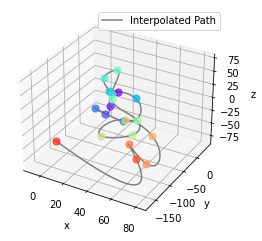

In [74]:
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20

template_chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)
visualize_polymer(template_chain)

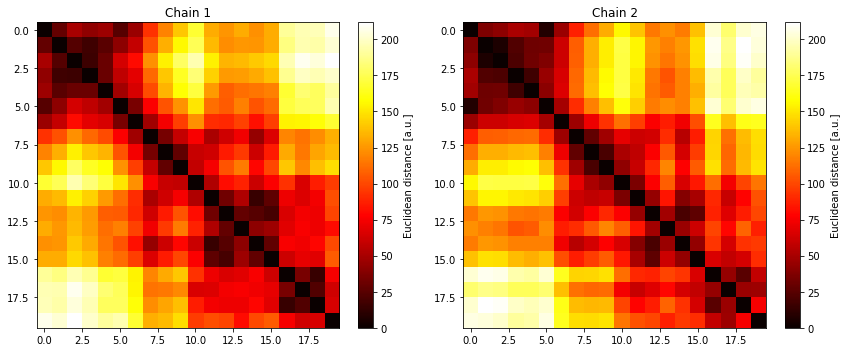

In [100]:
compare_distance_maps(template_chain, observation_list[observation_number])

In [164]:
def run_bayesian_update():
    empirical_distance_map_flat = generate_flatten_distance_map(template_chain)
    observation_distance_map_flat_list = [generate_flatten_distance_map(c) for c in observation_list]
    num_probes = num_monomers
    posterior_list = []
    
    for obs_index in range(len(observation_distance_map_flat_list)):
        if obs_index == 0:
            prior = calculate_gaussian_chain_conformation_prob(observation_list[obs_index])
        
        loglikelihood = calculate_loglikelihood(empirical_distance_map_flat, empirical_distance_map_flat, num_probes)
        print(loglikelihood)
        print(jnp.log(prior))
        unnormalized_posterior = jnp.log(prior) + loglikelihood

        posterior_list.append(unnormalized_posterior)
        prior = unnormalized_posterior
        print(prior)
        
    return posterior_list
         

In [146]:
calculate_loglikelihood(generate_flatten_distance_map(chain))

Array(2395.5266, dtype=float32)

In [165]:
posterior_list = run_bayesian_update()

-1288.6094
-18.4255
-1307.0349
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan
-1288.6094
nan
nan


In [166]:
posterior_list

[Array(-1307.0349, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, d

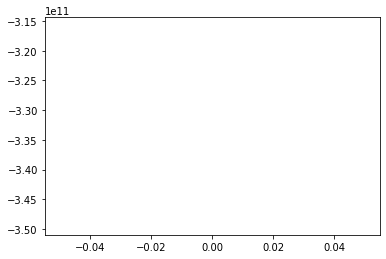

In [151]:
plt.plot(posterior_list)

## Maximum Likelihood Estimation using Jax

The following part of this notebook will provide a brief introduction to Jax and how to use automatic differentiation (AD) to perform maximum likelihood estimation (MLE). 

In [1]:
# import packages 
import jax
import numpy as np 
import jax.numpy as jnp
from scipy.optimize import minimize 
from jax.scipy import  optimize 

Then we generate data such that we can use Maximum Likelihood to estimate the parameters 

In [3]:
# Number of observations 
N = 5000 

# Number of parameters 
K = 2 

# True parameter values 
# beta = 2 * np.random.randn(K)
beta = 2 * np.ones(K) # np.array([2, 2])

# True error standard deviation 
sigma = 0.5

def datagen(N, beta, sigma):
    """
    Generates data for OLS regression 
    N: number of observations 
    beta: K x 1 true parameter values 
    sigma: standard deviation of error 
    """
    
    K = beta.shape[0]
    x_= 10 + 2 * np.random.randn(N, K-1)
    
    # x is the N x K data matrix with column of ones 
    # the first column estimates a constant
    x = np.c_[np.ones(N), x_]
    
    # y is the N x 1 vector of dependent variables 
    y = x.dot(beta) + sigma*np.random.randn(N)
    
    return y,x 

y, x = datagen(N, beta, sigma)

The following block of code defines the negative log-likelihood function. We have altered the return opf the likelihood function with the following code: 

```python
return (-1 * ll)/N
```

This rescaled likelihood function can help with the convergence of the optimization routine. 

Here the model is 
$$ Y = \beta^TX + \epsilon$$
where $\epsilon \approx \mathcal{N}(0, \sigma^2)$.

Therefore, $Y - \beta^TX$ should be normally distributed around 0 with standard deviation = $\sigma$.

The likelihood function for this estimation can then be written as 
$$\mathcal{L}(Y; X, \beta, \epsilon) = \prod_{i=1}^N\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)\exp\left[\frac{-(Y_i - \beta^TX_i)^2}{2\sigma^2} \right]
$$

The negative log-likehood then equals to 
$$
\mathcal{l}(Y; X, \beta, \epsilon) = \sum_{i=1}^N\left\{\left[\frac{1}{2}\log \left(2\pi\sigma^2\right)\right] + \left[ \frac{(Y_i - \beta^TX_i)^2}{2\sigma^2}\right]\right\}
$$


In [7]:
def neg_loglike(theta):
    beta = theta[:-1]
    
    # transform theta[-1]
    # so that sigma > 0
    sigma = jnp.exp(theta[-1])
    mu = jnp.dot(x, beta)
    ll = jnp.sum(jax.scipy.stats.norm.logpdf(y, loc=mu, scale=sigma))
    return -1*ll/N

In [8]:
jacobian = jax.jacfwd(neg_loglike)
hessian = jax.hessian(neg_loglike)

The next code block append $\beta$ and $\sigma$ to a vector called `theta`. Then the Jacobian and Hessians are evaluated at these values.

In [9]:
theta = jnp.append(beta, jnp.log(sigma))
print(f'Jacobian: {jacobian(theta)}\n')
print(f'Hessian:{hessian(theta)}')

Jacobian: [-0.0241592  -0.22509116 -0.0174517 ]

Hessian:[[3.9997649e+00 3.9954449e+01 4.8318282e-02]
 [3.9954449e+01 4.1551447e+02 4.5018262e-01]
 [4.8318401e-02 4.5018226e-01 2.0349033e+00]]


The next code block uses `scipy` minimize function to minimize the negative log-likelihood function. The method we use is `BFGS` and we add a tolerance option `gtol = 1e-7*N` to help with convergence. 

In [11]:
theta_start = jnp.append(jnp.zeros(beta.shape[0]), 0.0)
res1 = minimize(neg_loglike, theta_start, method='BFGS',
                options={'disp': True, 'gtol': 1e-7*N}, jac=jacobian)
print("Convergence Achieved: ", res1.success)
print("Number of Function Evaluations: ", res1.nfev)

Optimization terminated successfully.
         Current function value: 0.734362
         Iterations: 22
         Function evaluations: 31
         Gradient evaluations: 31
Convergence Achieved:  True
Number of Function Evaluations:  31


In [12]:
print(res1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.7343624234199524
        x: [ 2.016e+00  1.999e+00 -6.846e-01]
      nit: 22
      jac: [ 1.535e-05  1.686e-04  1.609e-05]
 hess_inv: [[ 6.486e+00 -6.248e-01  1.275e-02]
            [-6.248e-01  6.273e-02 -3.590e-04]
            [ 1.275e-02 -3.590e-04  5.165e-01]]
     nfev: 31
     njev: 31


In [13]:
print(f'Coefficient estimates: {res1.x[0]}, {res1.x[1]}')

new_sigma = np.exp(res1.x[-1])

print(f'Original sigma: {new_sigma}')

Coefficient estimates: 2.0159018869766436, 1.9990130838020947
Original sigma: 0.5043079494440934


Jax also has a built in minimization routine, which can be called with the next block of code. Note that the method option is restricted to BFGS at the time of writing.

In [21]:
res2 = jax.scipy.optimize.minimize(neg_loglike, theta_start, method='BFGS')

In [22]:
print(res2)

OptimizeResults(x=Array([ 0.59089136,  6.0974116 , -1.4891586 ], dtype=float32), success=Array(False, dtype=bool), status=Array(3, dtype=int32, weak_type=True), fun=Array(27.809149, dtype=float32), jac=Array([ -2.8311038, -29.31316  , -50.94435  ], dtype=float32), hess_inv=Array([[ 0.9984788 , -0.01576467, -0.03561225],
       [-0.01576467,  0.8366276 , -0.3690555 ],
       [-0.03561225, -0.3690555 ,  0.1670806 ]], dtype=float32), nfev=Array(6, dtype=int32, weak_type=True), njev=Array(6, dtype=int32, weak_type=True), nit=Array(2, dtype=int32, weak_type=True))
